In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import jax.numpy as jnp
import jax
import equinox as eqx

from tqdm import tqdm
import typing as tp

import sys
sys.path.append("/home/korolevki/mcmc-control-variates/diffcv")

import optax

sns.set_style("darkgrid")

## Gaussian Mixture

In [3]:
from dist import GaussianMixture
#mixture = GaussianMixture(np.array([-10, 10]), np.array([1, 1]))
dist_dim = 10
mixture = GaussianMixture(jnp.vstack([-10*jnp.ones((dist_dim), dtype=float), jnp.zeros((dist_dim), dtype=float), 10*jnp.ones((dist_dim), dtype=float)]), jnp.ones((3), dtype=float))
#mixture = GaussianMixture(jnp.vstack([10 * jnp.ones((dist_dim), dtype=float)]), jnp.ones((1), dtype=float))
grad_log_p = jax.jit(jax.grad(mixture.log_p))

2024-07-29 13:40:10.858453: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
rng = jax.random.PRNGKey(50)
rng, key = jax.random.split(rng)
data = mixture.sample(10000, key)

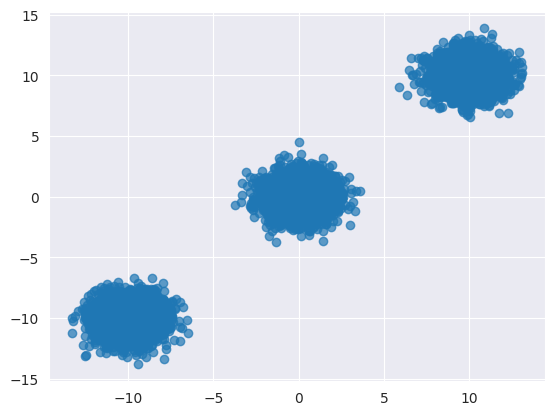

In [5]:
plt.scatter(data[:,0], data[:,1], alpha=0.7)
#plt.hist(data, bins=50, density=True)
plt.show()

## Langevin Dynamics (ULA)

In [6]:
from mcmc import LangevinDynamics, sample_multichain

In [7]:
rng, key = jax.random.split(rng)
sampler = LangevinDynamics(gradient_func=grad_log_p, n_samples=500, gamma=5e-2, burnin_steps=100)
samples = sample_multichain(sampler, dist_dim, key, n_chains = 100)

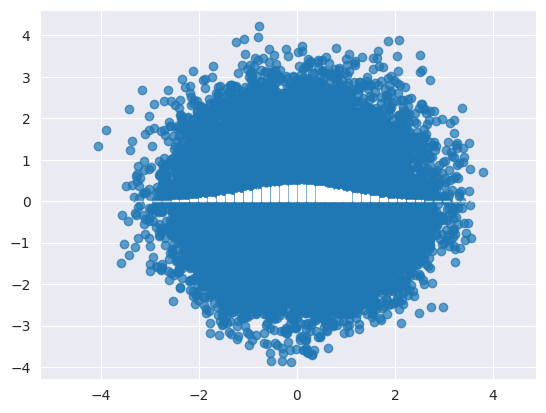

In [8]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.7)
print(jnp.any(np.isnan(samples)))
#plt.hist(samples, bins=50, density=True)
plt.show()

## Baseline
Using a sample mean as an integral estimate

In [9]:
from mcmc import estimate_n_mcmc

In [10]:
fn = jax.jit(lambda x: x.sum(axis=-1))
true_pi = jnp.dot(mixture.coeffs, mixture.means).sum()

true_pi

Array(0., dtype=float32)

In [11]:
MCMC_N_RUNS = 1000

False


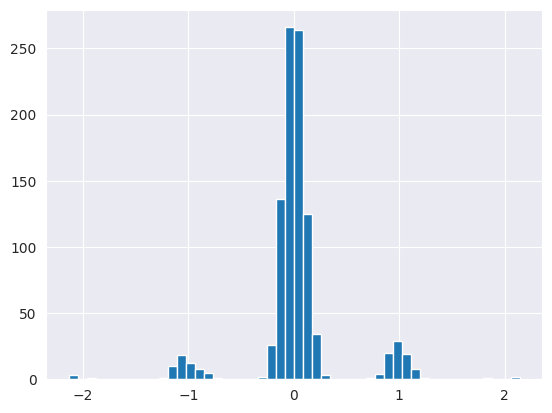

In [12]:
rng, key = jax.random.split(rng)
baseline_estimates = estimate_n_mcmc(fn, sampler, dist_dim, key, n_runs=MCMC_N_RUNS)

print(jnp.any(jnp.isnan(baseline_estimates)))
plt.hist(baseline_estimates, bins=50)
plt.show()

In [13]:
true_pi - baseline_estimates.mean(), baseline_estimates.std()

(Array(-0.02672612, dtype=float32), Array(0.41857094, dtype=float32))

## Control variates (Eric's structural risk)
Train a NN with an objective from "Diffusion Approximations and Control Variates for MCMC"

In [14]:
from diffcv.cv import ControlVariateModel, CVTrainer, CVLoss
from diffcv.logger import Logger
import jax_dataloader as jdl
from utils import inf_loop

2024-07-29 13:40:47.513474: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 13:40:47.513505: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 13:40:47.513528: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 13:40:48.329764: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
def plot_log_results(logger: Logger):
    log_results = logger.to_pandas()
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.lineplot(data=log_results["learning_rate"], ax=axes[0])
    sns.lineplot(data=log_results["loss"], ax=axes[1])
    fig.show()

In [16]:
rng, key = jax.random.split(rng)
training_samples = sample_multichain(sampler, dist_dim, key, n_chains = 100)
dataset = jdl.ArrayDataset(training_samples)
dataloader = jdl.DataLoader(
    dataset,
    backend="jax",
    batch_size=1024,
    shuffle=True
)
dataloader = inf_loop(dataloader)
len(dataset)

40000

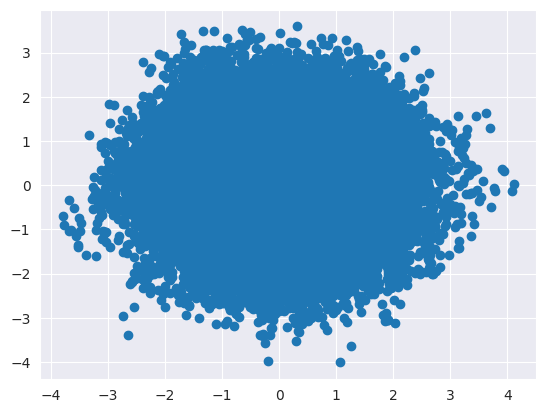

In [17]:
plt.scatter(x=dataset.arrays[0][:, 0], y=dataset.arrays[0][:, 1])
#plt.hist(dataset.arrays[0], bins=50)
plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

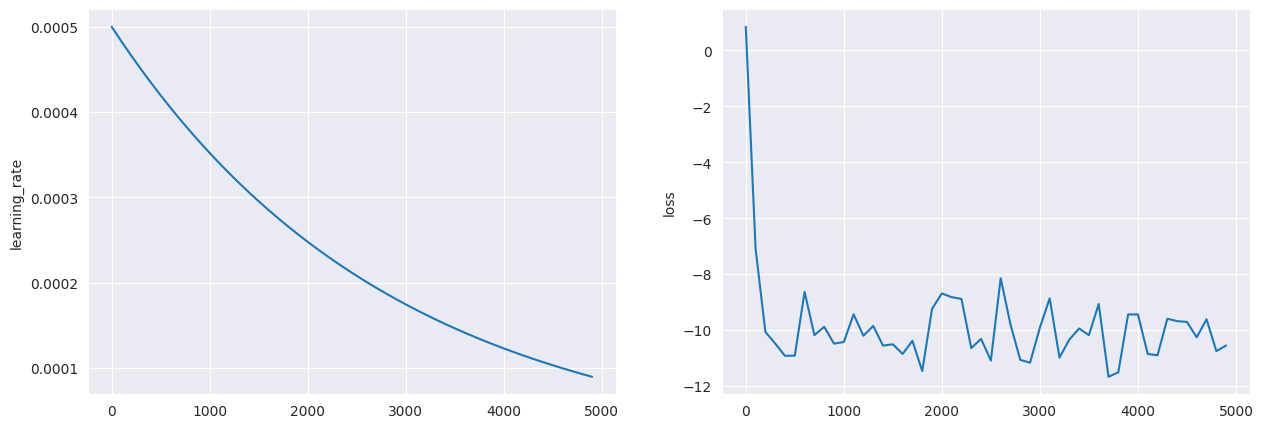

In [18]:
rng, key = jax.random.split(rng)
cv_model = ControlVariateModel(in_size=dist_dim, width_size=128, depth=1, key=key)
scheduler = optax.exponential_decay(init_value=5e-4, transition_steps=300, decay_rate=0.9)
optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=scheduler)
loss = CVLoss(fn=fn, l2_alpha=10)

logger = Logger()

cv_trainer = CVTrainer(cv_model, dataloader, optimizer, loss, logger, n_steps=5000)

cv_trainer.train(key)

plot_log_results(logger)

In [19]:
# Check NN for nans
rng, key = jax.random.split(rng)
x = jax.random.normal(key, shape=(100, dist_dim))
y = jax.vmap(cv_model)(x)
print(jnp.any(jnp.isnan(y)))

False


In [20]:
from diffcv.cv import Generator

In [21]:
# Expectation of generator with respect to distribution should be 0
generator = Generator(grad_log_p, cv_model)
jax.vmap(generator)(dataset.arrays[0]).mean()

Array(0.00373132, dtype=float32)

In [22]:
fn_with_cv = lambda x: fn(x) + generator(x)

In [23]:
# Check generator for nans
rng, key = jax.random.split(rng)
x = 1000 * jax.random.normal(key, shape=(100, dist_dim))
y = jax.vmap(generator)(x)
print(np.any(np.isnan(y)))

False


False


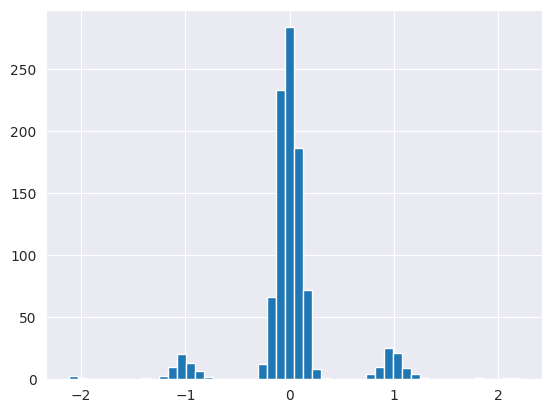

In [24]:
rng, key = jax.random.split(rng)
cv_estimates = estimate_n_mcmc(fn_with_cv, sampler, dist_dim, key, n_runs=MCMC_N_RUNS)

print(jnp.any(jnp.isnan(cv_estimates)))
plt.hist(cv_estimates, bins=50)
plt.show()

In [25]:
true_pi - baseline_estimates.mean(), baseline_estimates.std()

(Array(-0.02672612, dtype=float32), Array(0.41857094, dtype=float32))

In [26]:
true_pi - cv_estimates.mean(), cv_estimates.std()

(Array(-0.00938698, dtype=float32), Array(0.41236487, dtype=float32))

## Control variates (Diff Loss)

Use Stein equation to train NN on differences between different points

In [27]:
rng, key = jax.random.split(rng)
training_samples = sample_multichain(sampler, dist_dim, key, n_chains = 100)
dataset = jdl.ArrayDataset(training_samples)
dataloader = jdl.DataLoader(
    dataset,
    backend="jax",
    batch_size=1024,
    shuffle=True
)
dataloader = inf_loop(dataloader)
len(dataset)

40000

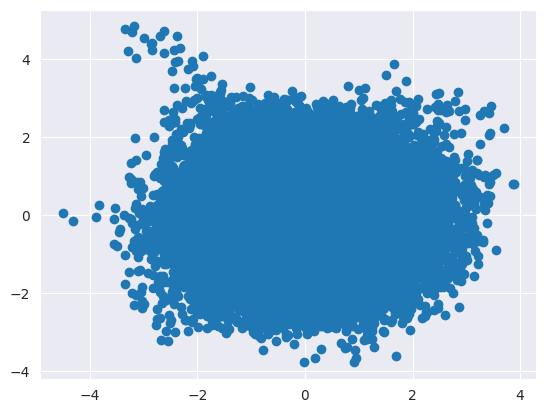

In [28]:
plt.scatter(x=dataset.arrays[0][:, 0], y=dataset.arrays[0][:, 1])
#plt.hist(dataset.arrays[0], bins=50)
plt.show()

In [29]:
from diffcv.cv import DiffLoss, CVALSLoss

  0%|          | 0/5000 [00:00<?, ?it/s]

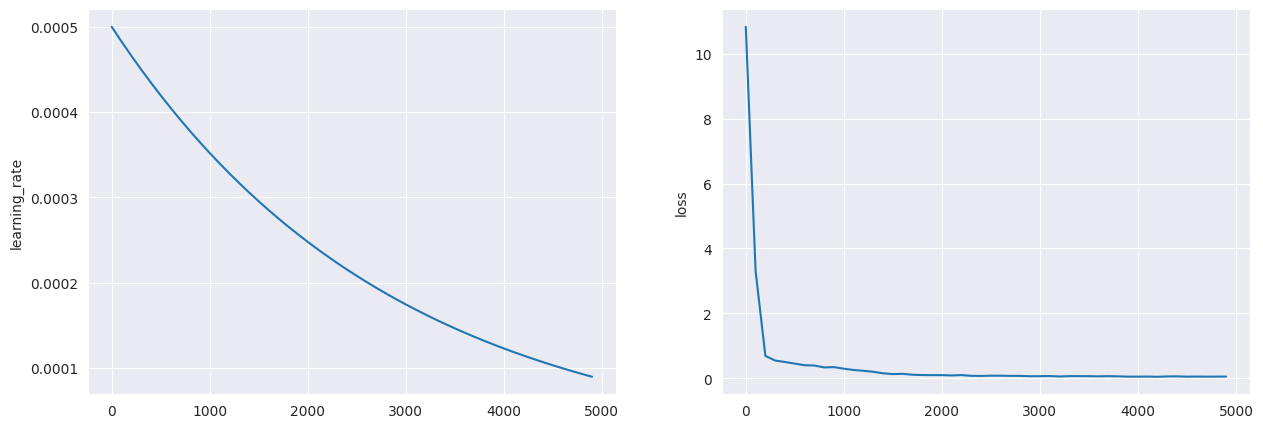

In [30]:
rng, key = jax.random.split(rng)

cv_diff_model = ControlVariateModel(in_size=dist_dim, width_size=128, depth=1, key=key)
scheduler = optax.exponential_decay(init_value=5e-4, transition_steps=300, decay_rate=0.9)
optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=scheduler)
loss = DiffLoss(fn=fn, grad_log_p=grad_log_p)

logger = Logger()

cv_diff_trainer = CVTrainer(cv_diff_model, dataloader, optimizer, loss, logger, n_steps=5000)
cv_diff_trainer.train(key)

plot_log_results(logger)

In [31]:
generator_diff = Generator(grad_log_p, cv_diff_model)
jax.vmap(generator_diff)(dataset.arrays[0]).mean()

Array(-0.01226167, dtype=float32)

In [32]:
fn_with_cv_diff = lambda x: fn(x) + generator_diff(x)

False


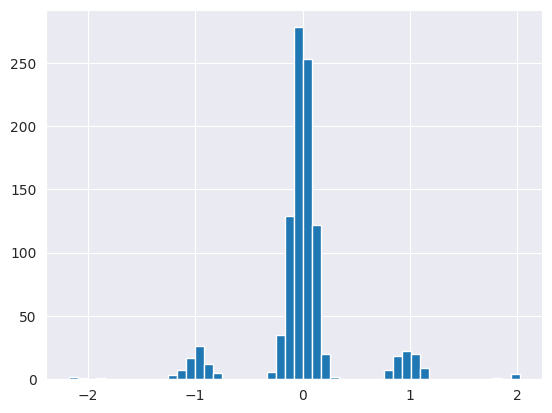

In [33]:
rng, key = jax.random.split(rng)
cv_diff_estimates = estimate_n_mcmc(fn_with_cv_diff, sampler, dist_dim, key, n_runs=MCMC_N_RUNS)

print(jnp.any(jnp.isnan(cv_diff_estimates)))
plt.hist(cv_diff_estimates, bins=50)
plt.show()

In [34]:
true_pi - baseline_estimates.mean(), baseline_estimates.std()

(Array(-0.02672612, dtype=float32), Array(0.41857094, dtype=float32))

In [35]:
true_pi - cv_estimates.mean(), cv_estimates.std()

(Array(-0.00938698, dtype=float32), Array(0.41236487, dtype=float32))

In [36]:
true_pi - cv_diff_estimates.mean(), cv_diff_estimates.std()

(Array(-0.00516025, dtype=float32), Array(0.43040118, dtype=float32))

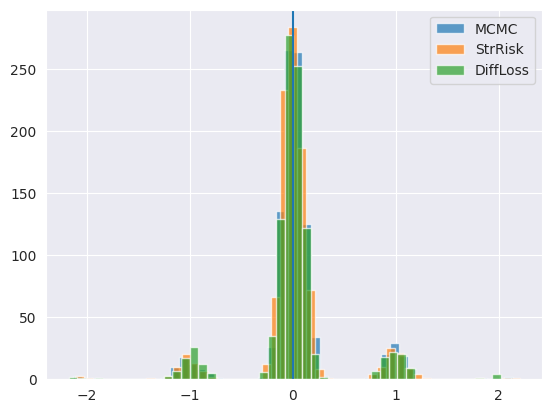

In [37]:
plt.hist(baseline_estimates, bins=50, alpha=0.7)
plt.hist(cv_estimates, bins=50, alpha=0.7)
plt.hist(cv_diff_estimates, bins=50, alpha=0.7)
plt.legend(["MCMC", "StrRisk", "DiffLoss"])
plt.axvline(x=true_pi)

plt.show()